#   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Text Summarizer

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> loading libraries  

In [1]:
import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import re #, string, unicodedata
#from   bs4 import BeautifulSoup

#from   textblob  import TextBlob, Word
from   wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import spacy

#from sklearn.svm           import SVC
#from sklearn.naive_bayes   import MultinomialNB
#from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model  import LogisticRegression, SGDClassifier
from sklearn               import model_selection, preprocessing, naive_bayes, ensemble 
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics       import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
import nltk   # pip install --upgrade nltk

nltk.download('punkt')
from nltk.probability      import FreqDist
#from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize         import word_tokenize, sent_tokenize

nltk.download('stopwords') 
from nltk.corpus           import stopwords

nltk.download('wordnet')
from nltk.stem             import WordNetLemmatizer 

#from nltk.stem            import LancasterStemmer 
#from nltk.stem.porter     import PorterStemmer

[nltk_data] Downloading package punkt to C:\Users\EZ-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\EZ-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\EZ-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> loading dataset

In [3]:
with open('Story_7.txt', 'r') as file:
    text = file.read().strip().replace('\n',' ').replace(';','.').replace('-',' ').replace('_',' ')
    
Clean_Text = ''
for word in word_tokenize(text):
    Clean_Text = Clean_Text + ' ' + word
text = Clean_Text

text

" ï » ¿ DOROTHY AND THE WIZARD IN OZ BY L. FRANK BAUM AUTHOR OF THE WIZARD OF OZ , THE LAND OF OZ , OZMA OF OZ , ETC . ILLUSTRATED BY JOHN R. NEILL BOOKS OF WONDER WILLIAM MORROW & CO. , INC. NEW YORK [ Illustration ] COPYRIGHT 1908 BY L. FRANK BAUM ALL RIGHTS RESERVED * * * * * [ Illustration ] DEDICATED TO HARRIET A . B. NEAL . * * * * * To My Readers It 's no use . no use at all . The children wo n't let me stop telling tales of the Land of Oz . I know lots of other stories , and I hope to tell them , some time or another . but just now my loving tyrants wo n't allow me . They cry : `` Oz Oz ! more about Oz , Mr . Baum ! '' and what can I do but obey their commands ? This is Our Book mine and the children 's . For they have flooded me with thousands of suggestions in regard to it , and I have honestly tried to adopt as many of these suggestions as could be fitted into one story . After the wonderful success of `` Ozma of Oz '' it is evident that Dorothy has become a firm fixture in 

In [4]:
data = pd.DataFrame( )
data['text'] = [text]
data.head()

,text
0,ï » ¿ DOROTHY AND THE WIZARD IN OZ BY L. FRAN...


#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> NLP Preprocessing

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Remove New Lines

In [5]:
# removing new lines
def remove_new_lines(text): return re.sub('[\n]',' ', text)
data['text'] = data['text'].apply(remove_new_lines)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Remove Punctuations

In [6]:
# removing punctuations
def remove_punctuations(text): return re.sub('[^a-zA-Z]',' ', text)
data['text'] = data['text'].apply(remove_punctuations)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Converting to LowerCase

In [7]:
# converting text to lower_case
def into_lower(text): return text.lower()
data['text'] = data['text'].apply(into_lower)

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Set & Remove Stop_Words

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Setting Stop_Words

In [8]:
# Setting English StopWords
stop_words = set( stopwords.words('english') )
new_words  = [ 'should', 'would', 'could', 'might' 
             ] 
stop_words = stop_words.union(new_words)

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> Iterate

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Removing Stop_Words

In [26]:
def remove_stop_words(text):
    Clean = []
    for word in text.split():
        if word.strip() not in stop_words:
            Clean.append(word.strip()) 
    return ' '.join( Clean )

data['text'] = data['text'].apply( remove_stop_words )
data['text'][0][:300]

'dorothy wizard oz l frank baum author wizard oz land oz ozma oz etc illustrate john r neill book wonder william morrow co inc new york illustration copyright l frank baum right reserve illustration dedicate harriet b neal reader use use child wo n let stop tale land oz lot story hope time love tyran'

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Lemmatizing

In [27]:
# Lemmatizing 
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    Clean = []
    for word in text.split():
        w = word
        w = lemmatizer.lemmatize(w, pos="n")   # nouns
        w = lemmatizer.lemmatize(w, pos="v")   # verbs
        w = lemmatizer.lemmatize(w, pos="a")   # adj
        w = lemmatizer.lemmatize(w, pos="r")   # adv
        w = lemmatizer.lemmatize(w, pos="s")   # satellite adj
        Clean.append( w )
    return ' '.join( Clean )

data['text'] = data['text'].apply(lemmatize_text)
data['text'][0][:300]

'dorothy wizard oz l frank baum author wizard oz land oz ozma oz etc illustrate john r neill book wonder william morrow co inc new york illustration copyright l frank baum right reserve illustration dedicate harriet b neal reader use use child wo n let stop tale land oz lot story hope time love tyran'

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Stemming
 - Faster but less accurate than Lemmatizer

In [28]:
# Stemming
''' 
Stemmer = PorterStemmer()

def stem_text(text):
    Clean = []
    for word in text.split():
        Clean.append( Stemmer.stem(word) )
    return ' '.join( Clean )

data['text'] = data['text'].apply(stem_text)
data.head()
''' 
pass

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Removing Stop_Words

In [29]:
data['text'] = data['text'].apply( remove_stop_words )
data['text'][0][:300]

'dorothy wizard oz l frank baum author wizard oz land oz ozma oz etc illustrate john r neill book wonder william morrow co inc new york illustration copyright l frank baum right reserve illustration dedicate harriet b neal reader use use child wo n let stop tale land oz lot story hope time love tyran'

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Bag of Words (List)

In [30]:
def bag_of_words_maker(df,ft):
    texts = df[ft]
    bag   = []
    for text in texts:
        for word in text.split():
            bag.append( word )
    return bag

bag_of_words = bag_of_words_maker( data, 'text' )
bag_of_words[:5]

['dorothy', 'wizard', 'oz', 'l', 'frank']

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Bag of Words (DataFrame)

In [31]:
bag_of_words = pd.DataFrame( bag_of_words, columns=['word'] )
bag_of_words.head(5)

,word
0,dorothy
1,wizard
2,oz
3,l
4,frank


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Words Count (DataFrame)

In [32]:
words_count         = pd.DataFrame( bag_of_words[ 'word' ].value_counts() )
words_count['word'] = words_count.index
words_count.index   = range( words_count.shape[0] )
words_count.head(15)

,count,word
0,267,wizard
1,257,dorothy
2,185,n
3,168,jim
4,143,horse
5,140,zeb
6,112,time
7,111,eureka
8,103,kitten
9,101,piglet


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Visualizing Top Words

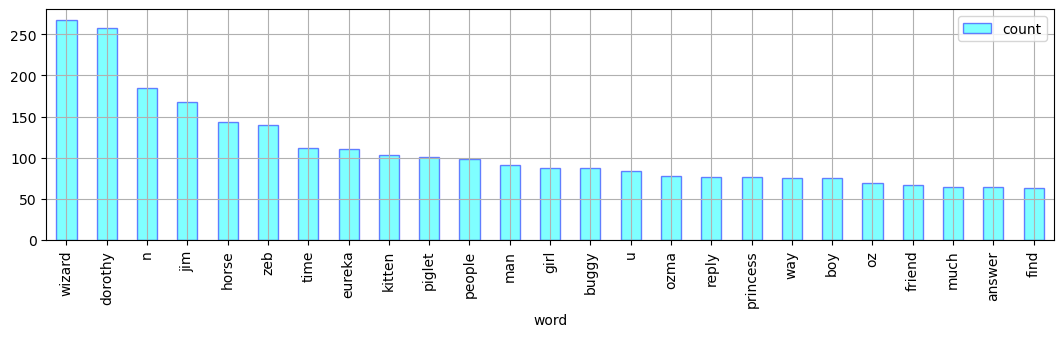

In [33]:
df = words_count
cat, sclr = 'word', 'count'

df.groupby(by=[cat])[sclr].median().reset_index().sort_values([sclr],ascending=False).head(25).\
plot( x=cat, y=sclr, kind='bar',  figsize=(13,3), color='cyan', edgecolor='blue', alpha=0.5, grid='on' ); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> new stop words

In [34]:
new_stop_words  = [ 'say', 'upon', 'well', 'mr', 'enough', 'yes', 'sir', 'go'
                  , 'back', 'see', 'think', 'come', 'like', 'around', 'tell', 'take'
                  , 'though', 'make', 'look', 'felt', 'saw', 'get'
                  ] 
stop_words = stop_words.union( new_stop_words )

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> Re-Iterate

#####   

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> Keeping Top Words

In [35]:
'''
n = 3000
Top_Words = words_count.loc[:n,'word'].tolist()
Top_Words[:5]
'''
pass

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Text Reduction

In [36]:
'''
def text_reduct( text ):
    Clean = []
    for word in text.split():
        if word in Top_Words:
            Clean.append(word)
    return ' '.join(Clean)

data['text'] = data['text'].apply(text_reduct)
#data['text'][0]
'''
pass

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Cool Image of Top Phrases

In [37]:
df = pd.DataFrame( )
df['text'] = [text]
df['text'] = df['text'].apply(remove_new_lines)
#df['text'] = df['text'].apply(remove_punctuations)
df['text'] = df['text'].apply(into_lower)

vec=CountVectorizer( min_df=0, max_df=500, binary=False, ngram_range=(2,4) ).fit( df['text'] )
bag=vec.transform(data['text'])

s = bag.sum(axis=0)
f = [ (word,s[0,idx]) for word, idx in vec.vocabulary_.items() ]
f = sorted( f, key=lambda x: x[1], reverse=True )
f[:50]

[('cab horse', 31),
 ('tin woodman', 19),
 ('princess ozma', 15),
 ('nine tiny', 15),
 ('emerald city', 15),
 ('woggle bug', 13),
 ('magic belt', 12),
 ('dorothy zeb', 11),
 ('hungry tiger', 10),
 ('real horse', 10),
 ('uncle henry', 9),
 ('black pit', 8),
 ('horse buggy', 8),
 ('invis ble', 8),
 ('mind eye', 8),
 ('humbug wizard', 7),
 ('earth surface', 7),
 ('fairy country', 7),
 ('fat piglet', 7),
 ('throne room', 7),
 ('glass city', 6),
 ('cowardly lion', 6),
 ('suit case', 5),
 ('hugson ranch', 5),
 ('wonderful wizard', 5),
 ('white piglet', 5),
 ('dama fruit', 5),
 ('pyramid mountain', 5),
 ('wicked witch', 5),
 ('nome king', 5),
 ('yellow hen', 5),
 ('nick chopper', 5),
 ('gid dap', 4),
 ('time dorothy', 4),
 ('horse jim', 4),
 ('every direction', 4),
 ('time jim', 4),
 ('pretty soon', 4),
 ('first time', 4),
 ('strange country', 4),
 ('bald head', 4),
 ('vegetable people', 4),
 ('veg table', 4),
 ('ever since', 4),
 ('half way', 4),
 ('answer zeb', 4),
 ('illustration jim', 4),

In [38]:
Top_N = 12
Top_Phrases = pd.DataFrame(f[:Top_N], columns=['Word','Freq'])
Freq_Max = Top_Phrases.loc[0,'Freq']
Top_Phrases.head()

,Word,Freq
0,cab horse,31
1,tin woodman,19
2,princess ozma,15
3,nine tiny,15
4,emerald city,15


In [39]:
Top_Corpus = []
for w in Top_Phrases['Word']:
    try:
        w1,w2,w3,w4 = w.split()
        Top_Corpus.append(str(w1+'_'+w2+'_'+w3+'_'+w4))
    except:
        try:
            w1,w2,w3 = w.split()
            Top_Corpus.append(str(w1+'_'+w2+'_'+w3))
        except:
            try:
                w1,w2 = w.split()
                Top_Corpus.append(str(w1+'_'+w2))
            except:
                Top_Corpus.append(str(w))
Top_Corpus = ' '.join(Top_Corpus)
Top_Corpus

'cab_horse tin_woodman princess_ozma nine_tiny emerald_city woggle_bug magic_belt dorothy_zeb hungry_tiger real_horse uncle_henry black_pit'

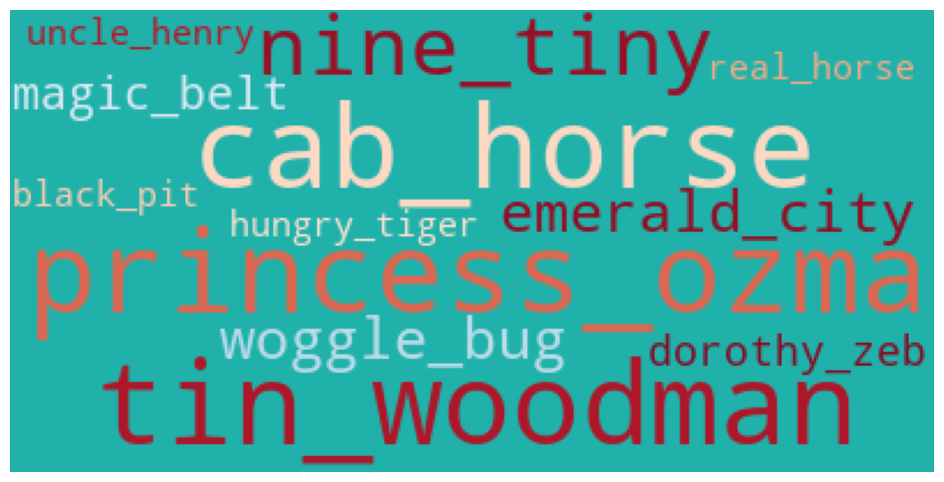

In [40]:
wordcloud = WordCloud( 
    
    background_color='LightSeaGreen', colormap='RdBu',
    #background_color='black', colormap='Greens',
    #background_color='black', colormap='Blues',
    
    stopwords        = stop_words,
    max_words        = Top_N,
    max_font_size    = 50,
    random_state     = 7 
    ).generate( str(Top_Corpus) ) 

fig = plt.figure(figsize=(13,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> TOP WORDS

In [43]:
# input
MIN_Repeat = 6   # minimum number of appearances in text

# auto
TOP_WORDS = []
for w in f:
    if w[1] >= MIN_Repeat:
        try:
            w1,w2,w3, w4 = w[0].split( )
            TOP_WORDS.append( w1 )
            TOP_WORDS.append( w2 )
            TOP_WORDS.append( w3 )
            TOP_WORDS.append( w4 )
        except:
            try:
                w1,w2,w3 = w[0].split( )
                TOP_WORDS.append( w1 )
                TOP_WORDS.append( w2 )
                TOP_WORDS.append( w3 )
            except:
                w1,w2 = w[0].split( )
                TOP_WORDS.append( w1 )
                TOP_WORDS.append( w2 )            
TOP_WORDS = list( set( TOP_WORDS ))
TOP_WORDS.sort()
print( len(TOP_WORDS), 'TOP_WORDS:  ', TOP_WORDS )

41 TOP_WORDS:   ['belt', 'black', 'ble', 'bug', 'buggy', 'cab', 'city', 'country', 'cowardly', 'dorothy', 'earth', 'emerald', 'eye', 'fairy', 'fat', 'glass', 'henry', 'horse', 'humbug', 'hungry', 'invis', 'lion', 'magic', 'mind', 'nine', 'ozma', 'piglet', 'pit', 'princess', 'real', 'room', 'surface', 'throne', 'tiger', 'tin', 'tiny', 'uncle', 'wizard', 'woggle', 'woodman', 'zeb']


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> new stop words

In [44]:
new_stop_words  = ['toward', 'quickly', 'never', 'open', 'know', 'hall', 'great', 'front', 'door', 'bus'
                  , 'last', 'still', 'suddenly', 'yeah' 
                  , 'another', 'ask', 'away', 'catch', 'chapter', 'distance', 'eat', 'good', 'great', 'inside', 'little', 'long', 'many', 'must', 'never', 'oh', 'old', 'one', 'run', 'voice'
                  ] 
stop_words = stop_words.union( new_stop_words )

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> Re-Iterate

#####   

#####   

In [45]:
MIN_REP = 10**10

for i in words_count.index:
    if words_count.loc[i,'count']>= MIN_REP:
        w = words_count.loc[i,'word'] 
        TOP_WORDS.append( w )           
TOP_WORDS = list( set( TOP_WORDS ))
TOP_WORDS.sort()
print( len(TOP_WORDS), 'TOP_WORDS:  ', TOP_WORDS )

41 TOP_WORDS:   ['belt', 'black', 'ble', 'bug', 'buggy', 'cab', 'city', 'country', 'cowardly', 'dorothy', 'earth', 'emerald', 'eye', 'fairy', 'fat', 'glass', 'henry', 'horse', 'humbug', 'hungry', 'invis', 'lion', 'magic', 'mind', 'nine', 'ozma', 'piglet', 'pit', 'princess', 'real', 'room', 'surface', 'throne', 'tiger', 'tin', 'tiny', 'uncle', 'wizard', 'woggle', 'woodman', 'zeb']


#####   

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Summary

In [46]:
# input
num_sentences = 25

# Calculate word frequencies
fdist = FreqDist( TOP_WORDS )

for i in words_count.index:
    w = words_count.loc[ i, 'word' ]
    if w in TOP_WORDS:
        freq = words_count.loc[ i, 'count' ]
        freq = min( Freq_Max, freq )
        fdist[ w ] = freq

# Assign scores to sentences based on word frequencies
sentences       = sent_tokenize( text )
sentence_scores = [ sum(fdist[word] for word in word_tokenize(
    lemmatizer.lemmatize( 
        lemmatizer.lemmatize( 
            lemmatizer.lemmatize( 
                lemmatizer.lemmatize( 
                    lemmatizer.lemmatize( sentence.lower()
                                        , pos="n" ), pos="v" ), pos="a" ), pos="r" ), pos="s" )
) if word in fdist) for sentence in sentences]


# Create a list of tuples containing sentence index and score
sentence_scores = list(enumerate(sentence_scores))

# Sort sentences by scores in descending order
sorted_sentences = sorted(sentence_scores, key=lambda x: x[1], reverse=True)

# Choosing top `num_sentences` sentences for the summary
chosen_sentences = sorted_sentences[:num_sentences]

# Sort the randomly selected sentences based on their original order in the text
summary_sentences = sorted(chosen_sentences, key=lambda x: x[0])

# Create the summary
summary = '/     ...     /'.join([sentences[i] for i, _ in summary_sentences])
summary

" ï » ¿ DOROTHY AND THE WIZARD IN OZ BY L. FRANK BAUM AUTHOR OF THE WIZARD OF OZ , THE LAND OF OZ , OZMA OF OZ , ETC ./     ...     /You will also become acquainted with Jim the Cab Horse , the Nine Tiny Piglets , and Eureka , the Kitten ./     ...     /LIST OF CHAPTERS CHAPTER PAGE 1 THE EARTHQUAKE 13 2 THE GLASS CITY 23 3 THE ARRIVAL OF THE WIZARD 41 4 THE VEGETABLE KINGDOM 55 5 DOROTHY PICKS THE PRINCESS 64 6 THE MANGABOOS PROVE DANGEROUS 77 7 INTO THE BLACK PIT AND OUT AGAIN 88 8 THE VALLEY OF VOICES 95 9 THEY FIGHT THE INVISIBLE BEARS 106 10 THE BRAIDED MAN OF PYRAMID MT 120 11 THEY MEET THE WOODEN GARGOYLES 131 12 A WONDERFUL ESCAPE 142 13 THE DEN OF THE DRAGONETTES 160 14 OZMA USES THE MAGIC BELT 172 15 OLD FRIENDS ARE REUNITED 187 16 JIM , THE CAB HORSE 203 17 THE NINE TINY PIGLETS 217 18 THE TRIAL OF EUREKA , THE KITTEN 231 19 THE WIZARD PERFORMS ANOTHER TRICK 240 20 ZEB RETURNS TO THE RANCH 251 [ Illustration ] CHAPTER 1 ./     ...     /This splendid group of colored suns sen

#####   

#####   